In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.integrate import simps
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

from mne import Epochs, pick_types, events_from_annotations, EpochsArray, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch, psd_array_multitaper, stft
import seaborn as sns
from tqdm import tqdm

In [2]:
# keras/tensorflow

import sys
import tensorflow.keras as keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout
from keras.regularizers import l2
import keras_tuner as kt
from keras.optimizers import Adam

import nengo
from nengo.utils.filter_design import cont2discrete
import nengo_dl

from keras_lmu import LMU
import keras_spiking


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas 1.5.2
Scikit-Learn 1.2.0
GPU is available


11490434/11490434 [==============================] - 2s 0us/step


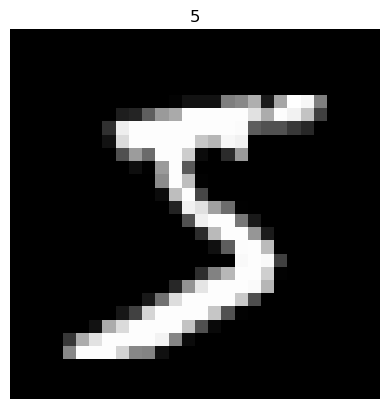

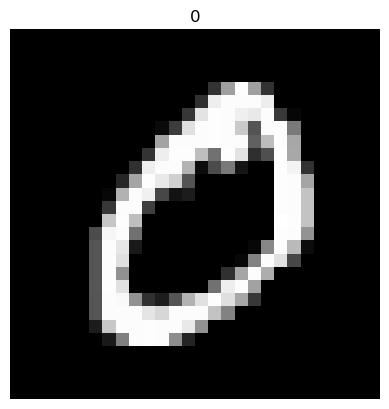

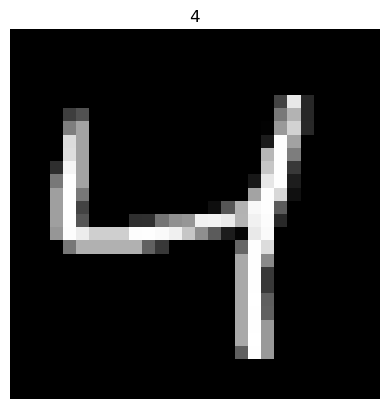

In [5]:
def load_mnist(plot=False, n_steps=30):
    (train_images, train_labels), (test_images, test_labels) = (
        tf.keras.datasets.mnist.load_data())

    # flatten images
    train_images = train_images.reshape((train_images.shape[0], -1))
    test_images = test_images.reshape((test_images.shape[0], -1))

    if plot:
        for i in range(3):
            plt.figure()
            plt.imshow(np.reshape(train_images[i], (28, 28)),
                       cmap="gray")
            plt.axis('off')
            plt.title(str(train_labels[i]));

    # add single timestep to training data
    train_images = train_images[:, None, :]
    train_labels = train_labels[:, None, None]

    # when testing our network with spiking neurons we will need to run it
    # over time, so we repeat the input/target data for a number of timesteps.
    test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
    test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

    return train_images, train_labels, test_images, test_labels

minibatch_size = 200
train_images, train_labels, test_images, test_labels = load_mnist(plot=True)

In [4]:
inp = keras.Input(shape=(28, 28, 1))
conv1 = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu,)(inp)
flatten = keras.layers.Flatten()(conv1)
dense1 = keras.layers.Dense(units=10)(flatten)

model = keras.Model(inputs=inp, outputs=dense1)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [7]:
converter = nengo_dl.Converter(model, swap_activations={tf.nn.relu: nengo.RectifiedLinear()})
net = converter.net
nengo_input = converter.inputs[inp]
nengo_output = converter.outputs[dense1]

# run training 
with nengo_dl.Simulator(net, seed=0, minibatch_size=128) as sim:
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
        metrics=["accuracy"],
    )
    sim.fit(train_images, {nengo_output: train_labels}, epochs=10)
    sim.save_params("./mnist_params")

|                     Building network (0%)                    | ETA:  --:--:--
|#####################Building network (76%)######               | ETA: 0:00:00
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:

/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/nengo-dl/nengo_dl/simulator.py:1736: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (3); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(
/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/nengo-dl/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (60000) is not evenly divisible by Simulator.minibatch_size (128); input data will be truncated.
  warnings.warn(


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
468/468 [==============================] - 15s 30ms/step - loss: 2.0848 - probe_loss: 2.0848 - probe_accuracy: 0.9292
Epoch 2/10
468/468 [==============================] - 14s 31ms/step - loss: 0.0659 - probe_loss: 0.0659 - probe_accuracy: 0.9814
Epoch 3/10
468/468 [==============================] - 15s 33ms/step - loss: 0.0370 - probe_loss: 0.0370 - probe_accuracy: 0.9896
Epoch 4/10
468/468 [==============================] - 14s 30ms/step - loss: 0.0230 - probe_loss: 0.0230 - probe_accuracy: 0.9933
Epoch 5/10
468/468 [==============================] - 14s 30ms/step - loss: 0.0149 - probe_loss: 0.0149 - probe_accuracy: 0.9961
Epoch 6/10
468/468

|                     Building network (0%)                    | ETA:  --:--:--
|#####################Building network (53%)                     | ETA: 0:00:00
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:

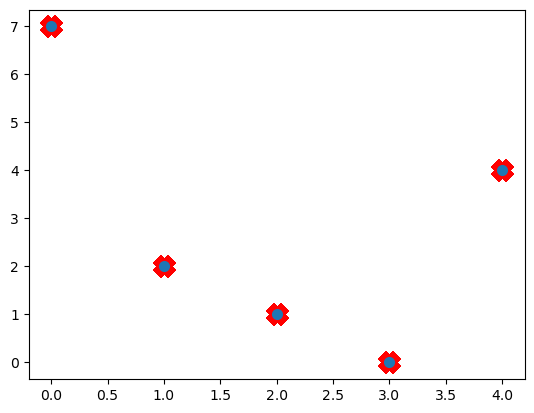

In [9]:
n_test = 5
params_file = "./mnist_params"
with nengo_dl.Simulator(net, seed=0) as sim:
    sim.load_params(params_file)
    data = sim.predict({nengo_input: test_images[:n_test]})
 
# plot the answer in a big red x
plt.plot(test_labels[:n_test].squeeze(), 'rx', mew=15)
# data[nengo_output].shape = (images, timesteps, n_outputs)
# plot predicted digit from network output on the last time step
plt.plot(np.argmax(data[nengo_output][:, -1], axis=1), 'o', mew=2)

NengoDL inherently accounts for time in its simulations and so the data all needs to be formatted as `(n_batches, n_timesteps, n_inputs)`. In this case everything is using standard rate mode neurons with no internal states that change over time, so simulating the network over time will generate the same output at every time step. When we move to spiking neurons, however, effects of temporal dynamics will be visible.

**Convert to spiking neurons**

To convert our network to spiking neurons, all we have to do is change the neuron activation function that we map to in the converter when we’re generating the net:



In [11]:
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
)
net = converter.net
nengo_input = converter.inputs[inp]
nengo_output = converter.outputs[dense1]
 
with nengo_dl.Simulator(net) as sim:
    sim.load_params("mnist_params")
    data = sim.predict({nengo_input: test_images[:n_test]})


|                     Building network (0%)                    | ETA:  --:--:--
|#####################Building network (76%)######               | ETA: 0:00:00
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:

So the process is that we create the model using Keras once. Then we can use a NengoDL Converter to create a Nengo network that can be simulated and trained. We save the parameters after training, and now we can use another Converter to create another instance of the network that uses SpikingRectifiedLinear neurons as the activation function. We can then load in the trained parameters that we got from simulating the standard RectifiedLinear rate mode activation function.

In [13]:

converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
)
net = converter.net
 
nengo_input = converter.inputs[inp]
nengo_output = converter.outputs[dense1]
# get a reference for the neurons that we want to probe
nengo_conv1 = converter.layers[conv1]
 
# add probe to the network to track the activity of those neurons!
with converter.net as net:
    probe_conv1 = nengo.Probe(nengo_conv1, label='probe_conv1')
 
with nengo_dl.Simulator(net) as sim:
    sim.load_params("mnist_params")
    data = sim.predict({nengo_input: test_images[:n_test]})

|                     Building network (0%)                    | ETA:  --:--:--
|#####################Building network (57%)                     | ETA: 0:00:00
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:

<AxesSubplot: >

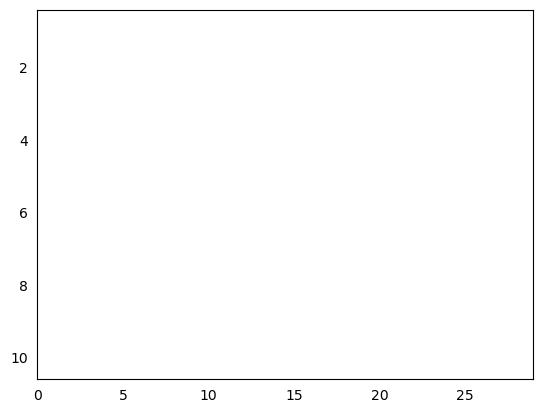

In [14]:

from nengo.utils.matplotlib import rasterplot
# plot results neural activity from the first n_neurons on the
# first batch (each image is a batch), all time steps
n_neurons = 10
n_timesteps = 30
rasterplot(np.arange(n_timesteps), data[probe_conv1][0, :, :n_neurons])


**IMPORTANT DISTINCTION**: rate neurons are the usual ANN neurons where the output of a non-linear activation function is considered the rate of the neuron

|                     Building network (0%)                    | ETA:  --:--:--
|#####################Building network (50%)                     | ETA: 0:00:00
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:

 ...]

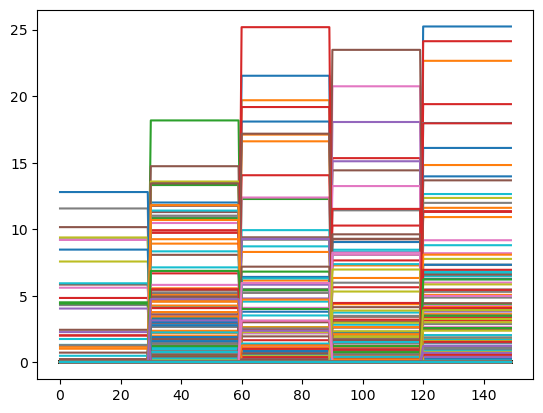

In [16]:

converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net
 
nengo_input = converter.inputs[inp]
nengo_output = converter.outputs[dense1]
nengo_conv1 = converter.layers[conv1]
 
with net:
    probe_conv1 = nengo.Probe(nengo_conv1)
 
with nengo_dl.Simulator(net) as sim:
    sim.load_params("mnist_params")
    data = sim.predict({nengo_input: test_images[:n_test]})
 
n_neurons = 5000
print('Max value: ', np.max(data[probe_conv1].flatten()))
# plot activity of first 5000 neurons, all inputs, all time steps
# we reshape the data so it's (n_batches * n_timesteps, n_neurons)
# for ease of plotting
plt.plot(data[probe_conv1][:, :, :n_neurons].reshape(-1, n_neurons))